In [1]:
## importing dataset
import pandas as pd
df = pd.read_csv("SHR65_22.csv")

In [2]:
## importing all libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import parallel_backend
from imblearn.over_sampling import SMOTE
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
import pickle


In [3]:
## Data preview
df.head()

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,Month,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197601001AKASP00,"Juneau, AK",AKASP00,Alaska,State Troopers,Primary state LE,FBI,Yes,1976,January,...,American Indian or Alaskan Native,Unknown or not reported,Knife or cutting instrument,Husband,Other arguments,NaN,0,0,30180.0,Rural Alaska
1,197601001AL00102,"Jefferson, AL",AL00102,Alabama,Birmingham,Municipal police,FBI,Yes,1976,January,...,Black,Unknown or not reported,Shotgun,Acquaintance,Felon killed by private citizen,Felon killed in commission of a crime,0,0,30180.0,"Birmingham-Hoover, AL"
2,197601001AL00104,"Jefferson, AL",AL00104,Alabama,Fairfield,Municipal police,FBI,Yes,1976,January,...,Black,Unknown or not reported,Shotgun,Wife,Other,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
3,197601001AL00106,"Jefferson, AL",AL00106,Alabama,Leeds,Municipal police,FBI,Yes,1976,January,...,Black,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180.0,"Birmingham-Hoover, AL"
4,197601001AL00201,"Mobile, AL",AL00201,Alabama,Mobile,Municipal police,FBI,Yes,1976,January,...,White,Unknown or not reported,Strangulation - hanging,Acquaintance,Circumstances undetermined,NaN,0,0,30180.0,"Mobile, AL"


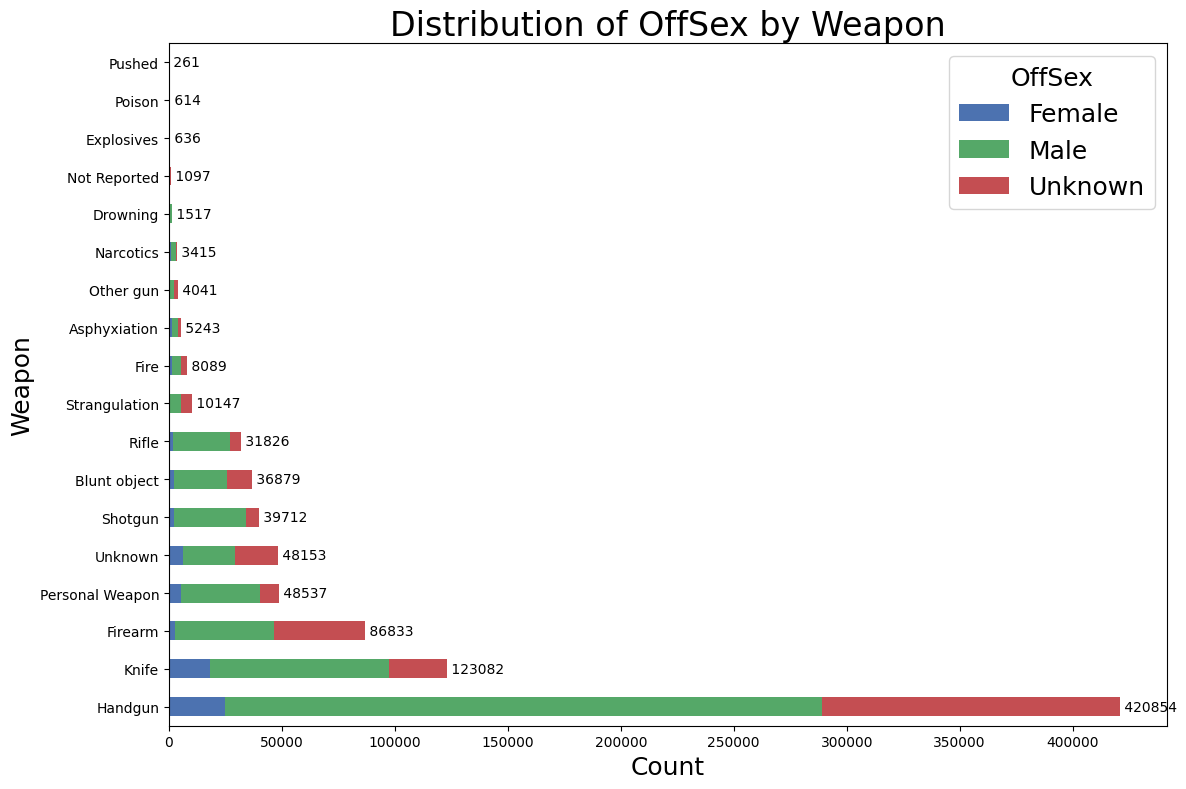

In [4]:
## Stacked bar chart of Weapon Distribution by OffSex
# Preprocess the Weapon column
df['Weapon'] = df['Weapon'].str.replace(r' - .*', '', regex=True)
df['Weapon'] = df['Weapon'].replace({
    'Narcotics or drugs, sleeping pills': 'Narcotics',
    'Firearm, type not stated': 'Firearm',
    'Knife or cutting instrument': 'Knife',
    'Other or type unknown': 'Unknown',
    'Personal weapons, includes beating': 'Personal Weapon',
    'Pushed or thrown out window': 'Pushed',
    'Weapon Not Reported': 'Not Reported'
})

# Get the counts for Weapon and OffSex combinations
weapon_offsex_counts = df.groupby(['Weapon', 'OffSex']).size().unstack(fill_value=0)

# Get the total counts for each Weapon
weapon_totals = weapon_offsex_counts.sum(axis=1)
# Sort weapons by total count (descending) and get top 18
top_weapons = weapon_totals.sort_values(ascending=False).head(18)
weapon_offsex_counts = weapon_offsex_counts.loc[top_weapons.index]

# Create the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for OffSex categories
colors = ['#4C72B0', '#55A868', '#C44E52']  # Blue, Green, Red for Male, Female, Unknown

# Plot the stacked bars
weapon_offsex_counts.plot(kind='barh', stacked=True, color=colors, ax=ax)

# Customize the plot
ax.set_xlabel('Count', fontsize=18)
ax.set_ylabel('Weapon', fontsize=18)
ax.set_title('Distribution of OffSex by Weapon', fontsize=24)
ax.legend(title='OffSex', title_fontsize=18, fontsize=18)  # Increase legend title and label font size

# Add the total count to the end of each bar
for i, (total, weapon) in enumerate(zip(top_weapons, top_weapons.index)):
    ax.text(total, i, f' {total}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


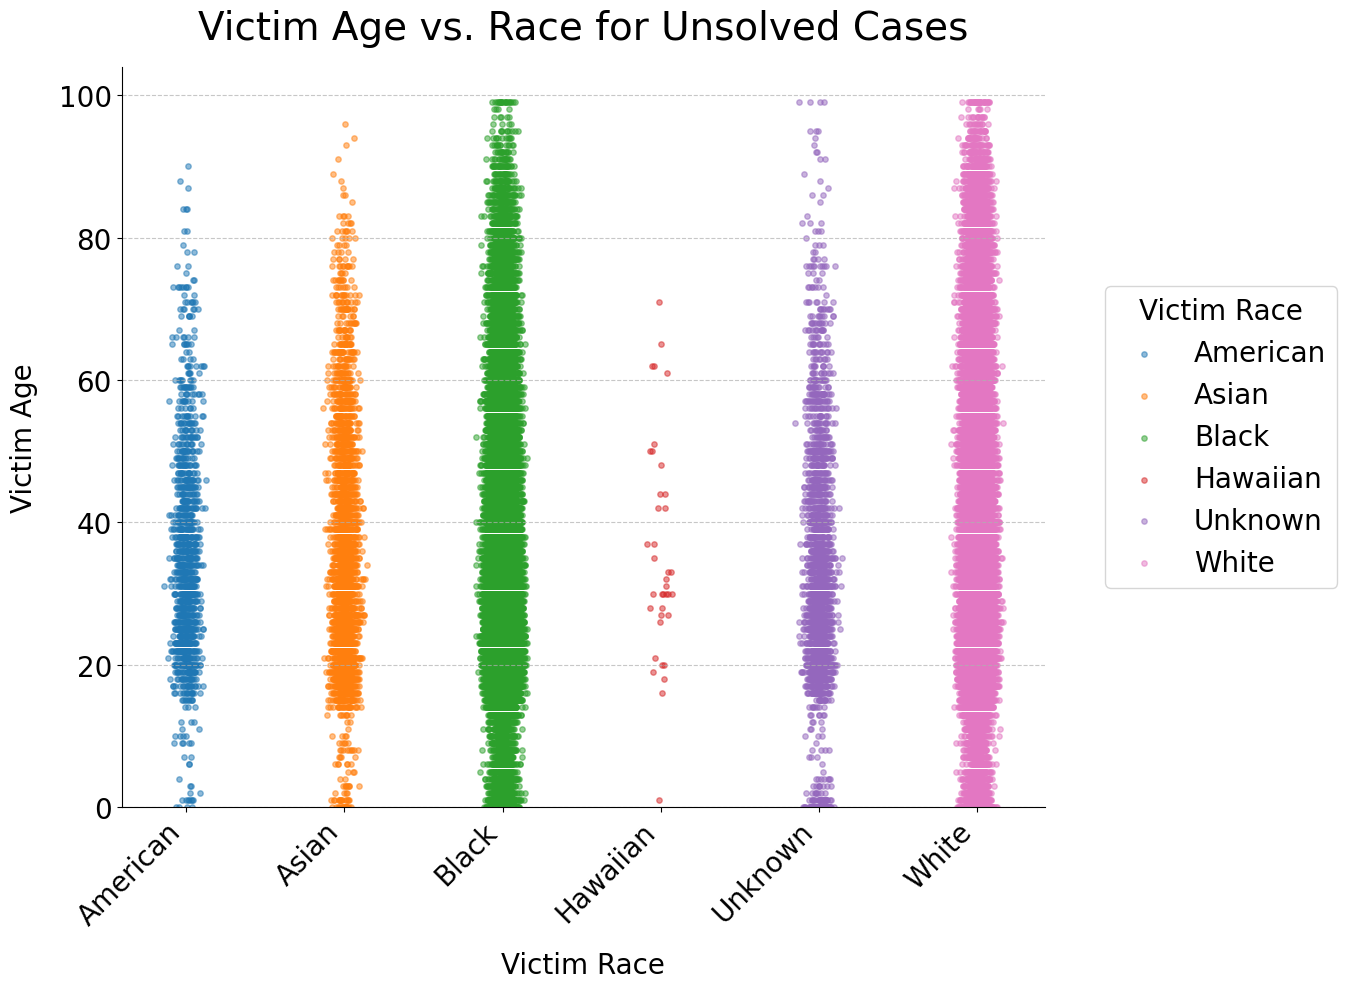

In [5]:
## Dot Plot of Victim Age vs Race excluding 999 in unsolved cases
# Remove rows where VicAge is 999 directly in the main DataFrame
df = df[df['VicAge'] != 999]

# Define custom color mapping for each Victim Race category with updated labels
color_mapping = {
    'American': '#1f77b4',  # Changed from 'American Indian or Alaskan Native'
    'Asian': '#ff7f0e',
    'Black': '#2ca02c',
    'Hawaiian': '#d62728',  # Changed from 'Native Hawaiian or Pacific Islander'
    'Unknown': '#9467bd',
    'White': '#e377c2'
}

# Filter the DataFrame for unsolved cases before plotting
unsolved_cases = df[df['Solved'] == 'No']

# Update the race labels in the DataFrame
unsolved_cases.loc[:, 'VicRace'] = unsolved_cases.loc[:, 'VicRace'].replace({
    'American Indian or Alaskan Native': 'American',
    'Native Hawaiian or Pacific Islander': 'Hawaiian'
})

# Group by Victim Race and aggregate Victim Ages
race_groups = unsolved_cases.groupby('VicRace')['VicAge'].apply(list)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each race
for i, (race, ages) in enumerate(race_groups.items()):
    x = np.random.normal(i, 0.04, len(ages))
    ax.scatter(x, ages, alpha=0.5, s=15, color=color_mapping.get(race, '#333333'), label=race)

# Customize plot elements
ax.set_title('Victim Age vs. Race for Unsolved Cases', fontsize=28, pad=20)
ax.set_xlabel('Victim Race', fontsize=20, labelpad=15)
ax.set_ylabel('Victim Age', fontsize=20, labelpad=15)

# Move legend outside the plot to the right
ax.legend(title='Victim Race', loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fontsize=20, title_fontsize=20)

# Set x-ticks
ax.set_xticks(range(len(race_groups)))
ax.set_xticklabels(race_groups.keys(), rotation=45, ha='right')

# Add a slight grid for the y-axis only
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0, unsolved_cases['VicAge'].max() + 5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

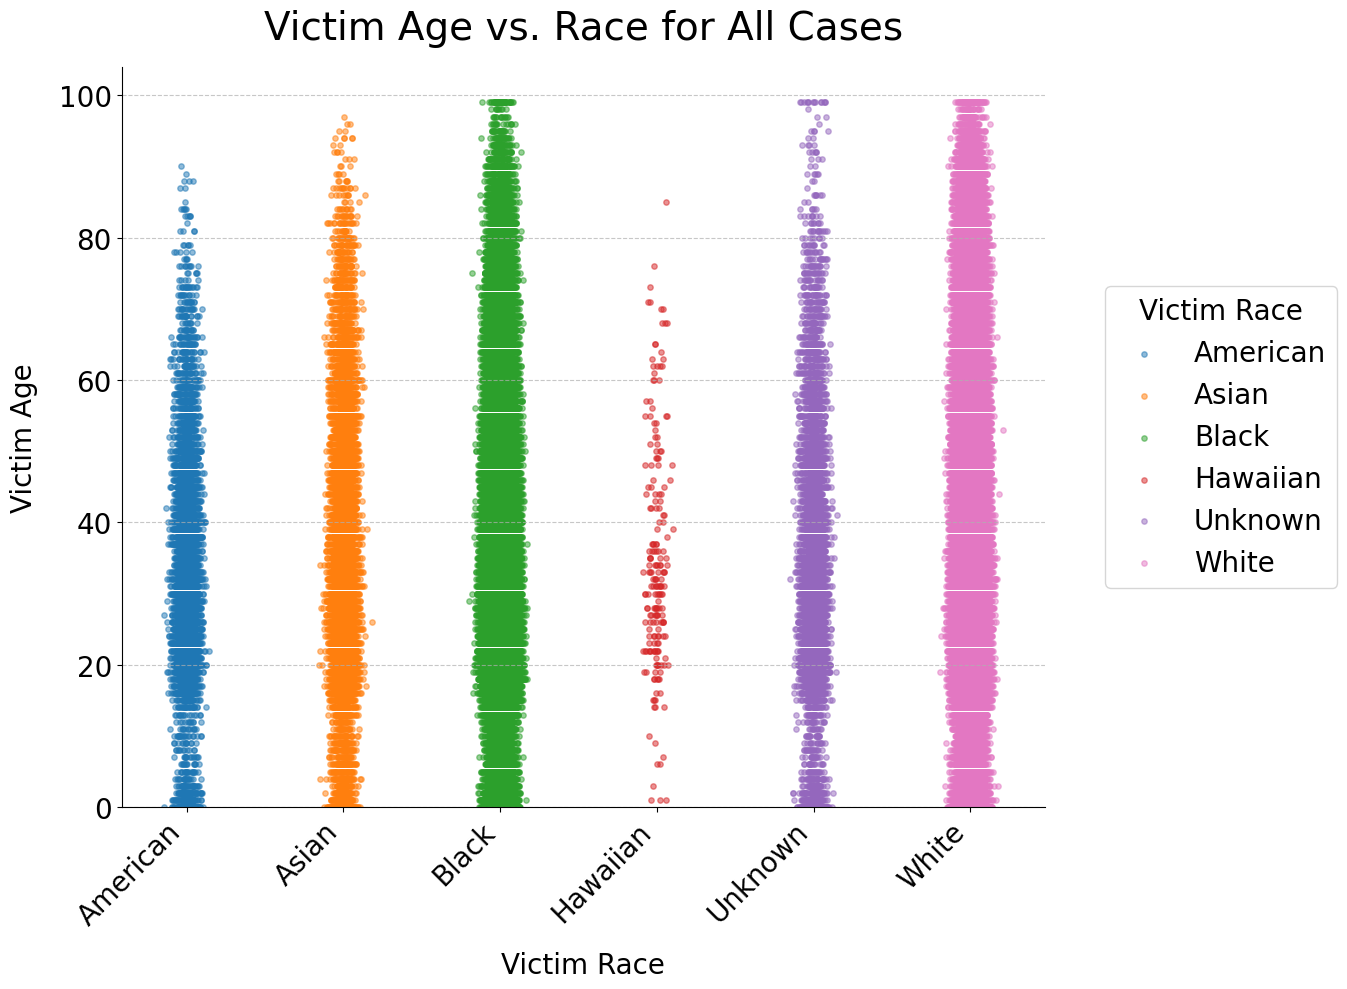

In [6]:
## Dot Plot of Victim Age vs Race excluding 999 in all cases
# Load your data file
df = df[df['VicAge'] != 999]

# Define custom color mapping for each Victim Race category with updated labels
color_mapping = {
    'American': '#1f77b4',  # Changed from 'American Indian or Alaskan Native'
    'Asian': '#ff7f0e',
    'Black': '#2ca02c',
    'Hawaiian': '#d62728',  # Changed from 'Native Hawaiian or Pacific Islander'
    'Unknown': '#9467bd',
    'White': '#e377c2'
}

# Update the race labels in the DataFrame
df['VicRace'] = df['VicRace'].replace({
    'American Indian or Alaskan Native': 'American',
    'Native Hawaiian or Pacific Islander': 'Hawaiian'
})

# Group by Victim Race and aggregate Victim Ages
race_groups = df.groupby('VicRace')['VicAge'].apply(list)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))  # Increased figure size

# Plot each race
for i, (race, ages) in enumerate(race_groups.items()):
    # Add some jitter to x positions
    x = np.random.normal(i, 0.04, len(ages))
    ax.scatter(x, ages, alpha=0.5, s=15, color=color_mapping.get(race, '#333333'), label=race)

# Customize plot elements
ax.set_title('Victim Age vs. Race for All Cases', fontsize=28, pad=20)
ax.set_xlabel('Victim Race', fontsize=20, labelpad=15)
ax.set_ylabel('Victim Age', fontsize=20, labelpad=15)

# Move legend outside the plot to the right
ax.legend(title='Victim Race', loc='center left', bbox_to_anchor=(1.05, 0.5),
          ncol=1, fontsize=20, title_fontsize=20)

# Set x-ticks
ax.set_xticks(range(len(race_groups)))
ax.set_xticklabels(race_groups.keys(), rotation=45, ha='right')

# Add a slight grid for the y-axis only
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0, df['VicAge'].max() + 5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjusted right margin for legend
plt.show()

## Machine learning

### Pre-processing

In [7]:
## Removing unsolved cases
solved_data = df[df['Solved'] == 'Yes']
# Filter out invalid OffAge and OffSex
solved_data = solved_data[(solved_data['OffAge'] != 999) & (solved_data['OffSex'] != 'Unknown')]
solved_data = solved_data[solved_data['VicSex'] != 'Unknown']

In [8]:
## Removing Useless columns
# Drop irrelevant columns
solved_data = solved_data.drop(columns=['ID',                    #unique IDs of cases
                                        'Solved',                #all rows are "Yes"
                                        'VicEthnic', 'OffEthnic',#Most rows are "Unknown or not reported"
                                        'OffRace',               #Unsolved cases don't have any information on Offender
                                        'VicCount', 'OffCount',  #Most rows are empty
                                        'FileDate',              #Just date
                                        'MSA',                   #Redundant with CNTYFIPS and State columns
                                        'Relationship',          #Unsolved cases relationships are unknown
                                        'Circumstance',          #Unsolved cases "unknown"
                                        'Subcircum',             #Mostly empty
                                        'Ori',                   #Combination of Source and Agency
                                        'Incident',              #Case numbers within the month
                                        'CNTYFIPS',              #Very high cardinality
                                        'Agency',                #Very high cardinality
                                        'Situation'              #Unsolved cases set to "Unknown Offender"
                                        ])

### Testing numerical columns for Linear ML methods

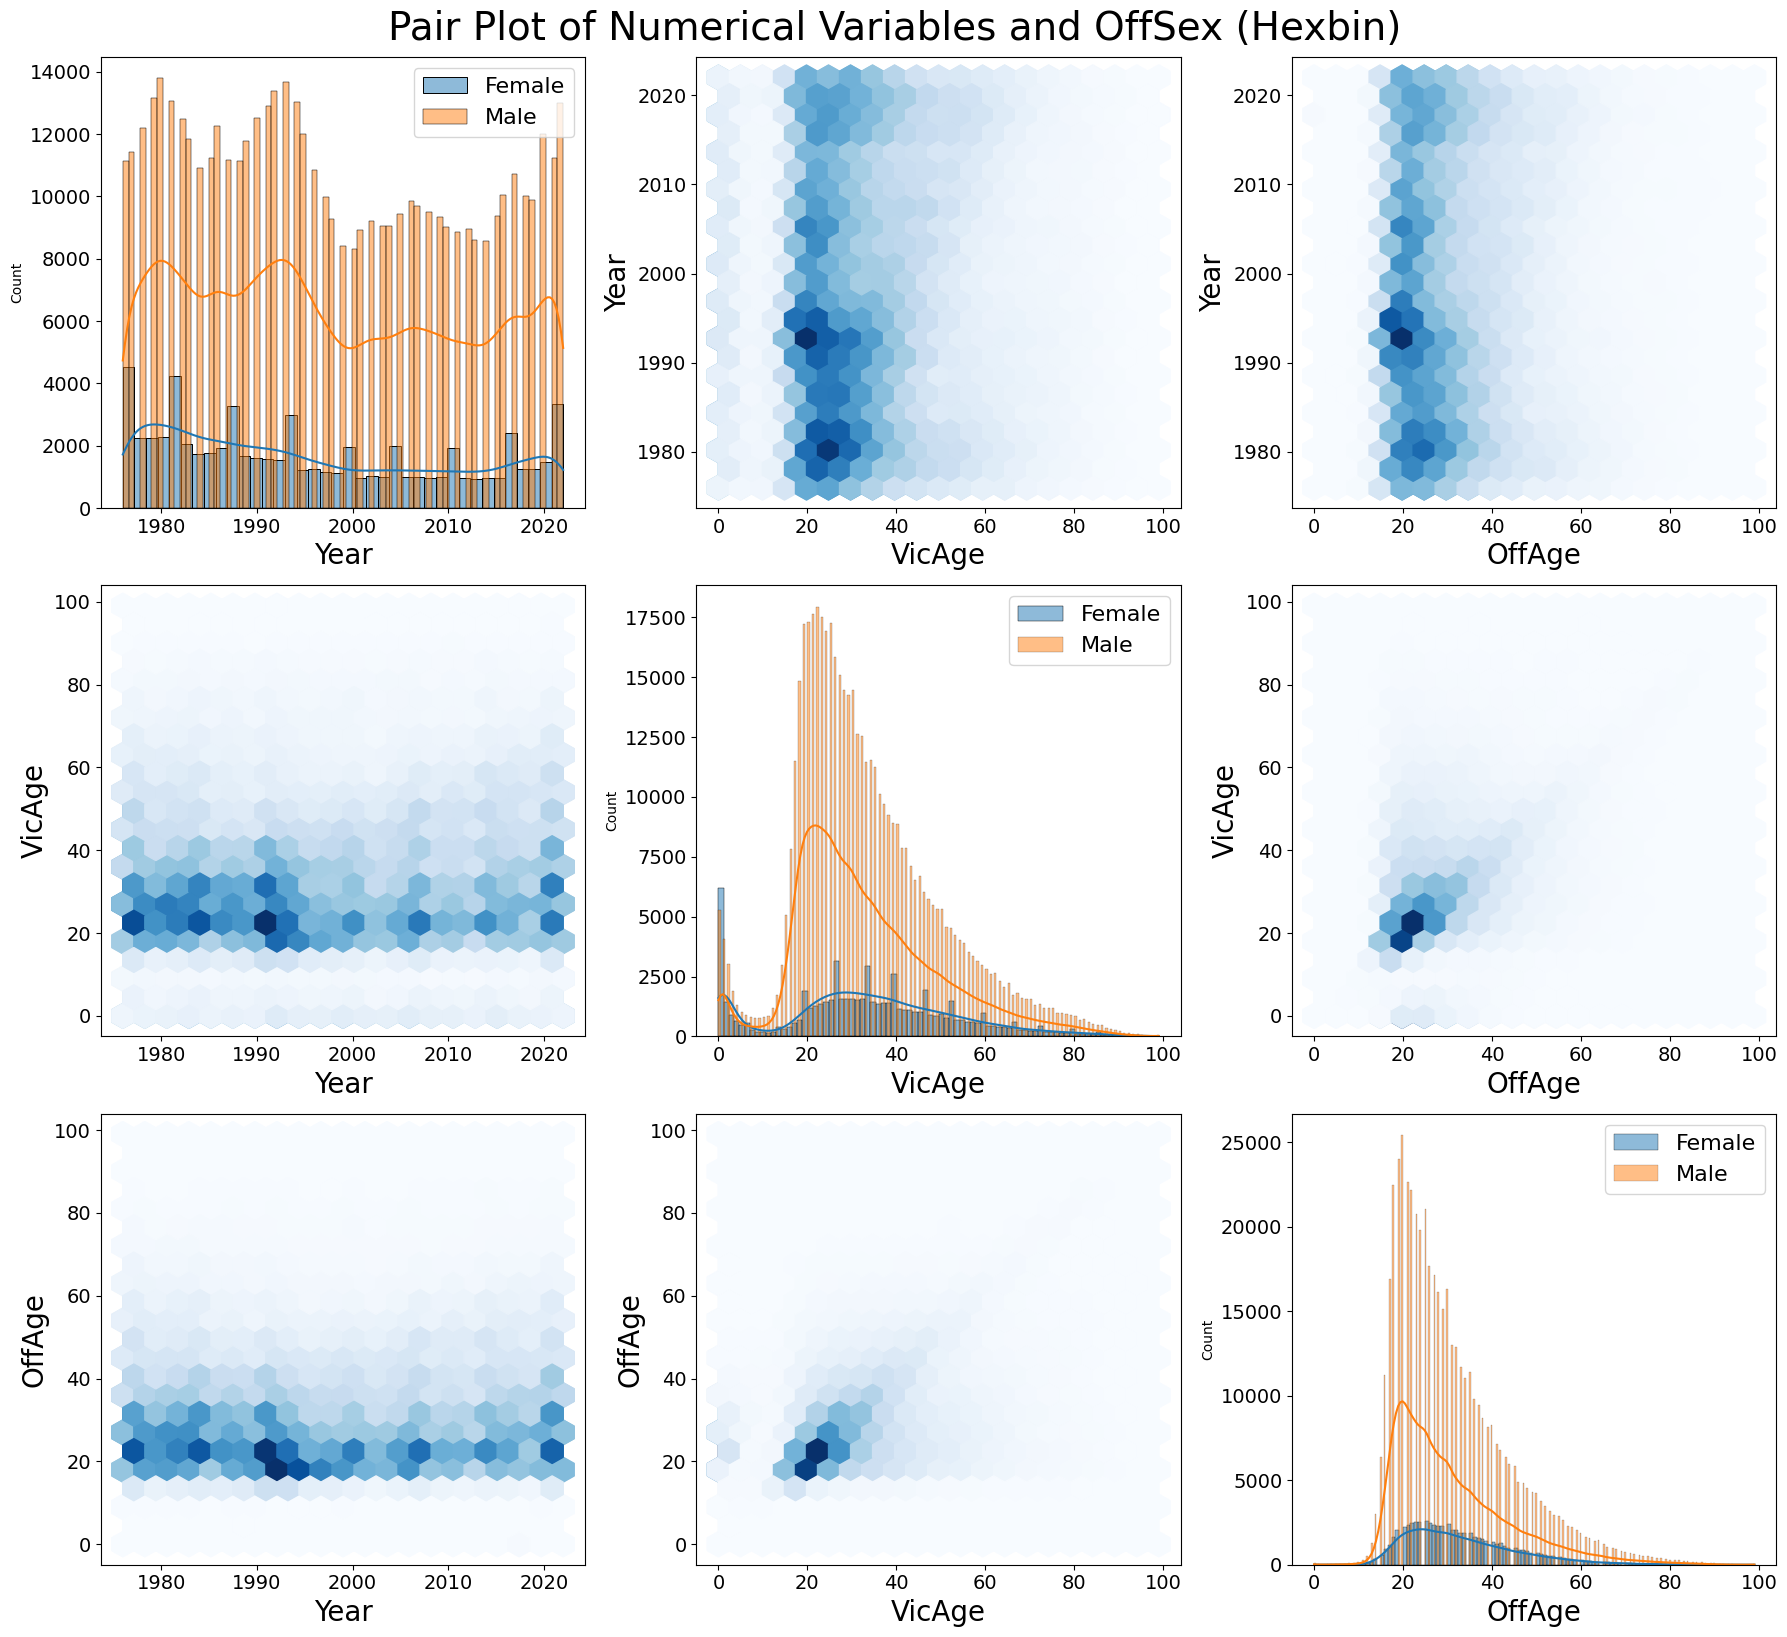

In [9]:
## Logistic regression is not viable in Regression of OffAge

# Assuming solved_data is your DataFrame
numerical_cols = ['Year', 'VicAge', 'OffAge']
plot_cols = numerical_cols + ['OffSex']

# Create custom pair plot with hexbin plots
def custom_pairplot(data, vars, hue, diag_kind='hist'):
    n_vars = len(vars)
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(18, 16))
   
    for i, var1 in enumerate(vars):
        for j, var2 in enumerate(vars):
            ax = axes[i, j]
            if i != j:
                for category in data[hue].unique():
                    subset = data[data[hue] == category]
                    ax.hexbin(subset[var2], subset[var1], gridsize=20, cmap='Blues')
                ax.set_xlabel(var2, fontsize=20)
                ax.set_ylabel(var1, fontsize=20)
            else:
                if diag_kind == 'hist':
                    for category in data[hue].unique():
                        subset = data[data[hue] == category]
                        sns.histplot(subset[var1], ax=ax, kde=True, label=category)
                    ax.legend(fontsize=16)
                ax.set_xlabel(var1, fontsize=20)
            
            ax.tick_params(axis='both', which='major', labelsize=14)
   
    plt.tight_layout()
    plt.suptitle("Pair Plot of Numerical Variables and OffSex (Hexbin)", y=1.02, fontsize=28)
    plt.show()

# Create custom pair plot
custom_pairplot(solved_data[plot_cols], vars=numerical_cols, hue='OffSex')


### Testing Permutation importances for tree based regression(OffAge) and classification(OffSex)

In [10]:
## Permutaion Feature importances for decision tree regrerssor -  OffAge

# Create a copy of the solved_data
data_copy = solved_data.copy()

# Identify numeric and categorical columns
numeric_cols = data_copy.select_dtypes(include=[np.number]).columns
categorical_cols = data_copy.select_dtypes(exclude=[np.number]).columns

# Encode categorical variables
le = LabelEncoder()
for col in categorical_cols:
    data_copy[col] = le.fit_transform(data_copy[col].astype(str))

# Prepare the data
X = data_copy.drop('OffAge', axis=1)
y = data_copy['OffAge']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Calculate permutation importances
results = permutation_importance(dt_model, X_test, y_test, scoring='r2')
importances = results.importances_mean

# Print top 10 features for the model
def print_top_features(importances, feature_names, title, n=10):
    indices = np.argsort(importances)[::-1]
    print(f"\nTop {n} features for {title}:")
    for i in range(n):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

print_top_features(importances, X.columns, "Decision Tree")

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R-squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

print("\nDecision Tree Performance:")
evaluate_model(dt_model, X_test, y_test)



Top 10 features for Decision Tree:
VicAge: 0.3854
Weapon: 0.1242
Year: 0.0943
VicSex: 0.0731
State: 0.0512
VicRace: 0.0426
OffSex: 0.0373
Agentype: 0.0196
Month: 0.0194
ActionType: 0.0132

Decision Tree Performance:
R-squared: -0.5410
RMSE: 16.1253


In [11]:
## Permutaion Feature importances for decision tree classifiers -  OffSex
# Create a copy of the solved_data
data_copy = solved_data.copy()

# Identify numeric and categorical columns
numeric_cols = data_copy.select_dtypes(include=[np.number]).columns
categorical_cols = data_copy.select_dtypes(exclude=[np.number]).columns

# Encode categorical variables
le = LabelEncoder()
for col in categorical_cols:
    data_copy[col] = le.fit_transform(data_copy[col].astype(str))

# Encode target variable 'OffSex'
le_target = LabelEncoder()
data_copy['OffSex'] = le_target.fit_transform(data_copy['OffSex'].astype(str))

# Prepare the data
X = data_copy.drop('OffSex', axis=1)
y = data_copy['OffSex']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Calculate permutation importances
results = permutation_importance(dt_model, X_test, y_test, scoring='accuracy')
importances = results.importances_mean

# Print top 10 features for the model
def print_top_features(importances, feature_names, title, n=10):
    indices = np.argsort(importances)[::-1]
    print(f"\nTop {n} features for {title}:")
    for i in range(n):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

print_top_features(importances, X.columns, "Decision Tree")

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

print("\nDecision Tree Performance:")
evaluate_model(dt_model, X_test, y_test)


Top 10 features for Decision Tree:
Weapon: 0.0145
VicAge: 0.0113
OffAge: 0.0106
VicSex: 0.0090
Year: 0.0082
State: 0.0058
VicRace: 0.0050
Month: 0.0020
Agentype: 0.0011
Homicide: 0.0009

Decision Tree Performance:
Accuracy: 0.8131
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.28      0.26     13290
           1       0.90      0.88      0.89    101345

    accuracy                           0.81    114635
   macro avg       0.57      0.58      0.58    114635
weighted avg       0.83      0.81      0.82    114635



In [12]:
## Drop irrelevant columns and creating datasets for regression and classification

# Create Regression Dataset
regression_columns = ['OffAge', 'VicAge', 'Weapon', 'Year', 'VicSex', 'State', 'VicRace',
                      'OffSex', 'Agentype', 'Month']
regression_data = solved_data[regression_columns]

# Create Classification Dataset
classification_columns = ['Weapon', 'VicAge', 'OffSex', 'VicSex', 'Year', 'State', 'VicRace',
                          'Month']
classification_data = solved_data[classification_columns]

### Trying different tree based techniques for regression

In [13]:
## XGboost regression on normal dataset
X = regression_data.drop(columns=['OffAge'])  # Features
y = regression_data['OffAge'].values  # Target variable

# Define categorical and numerical columns
categorical_cols = ['Weapon', 'VicSex', 'State', 'VicRace', 'Agentype', 'Month']
numerical_cols = ['VicAge', 'Year']

# Check that all columns used in preprocessing exist in the DataFrame
missing_cols = [col for col in categorical_cols + numerical_cols if col not in X.columns]
if missing_cols:
    raise ValueError(f"Missing columns in the DataFrame: {missing_cols}")

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model with updated parameters
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    tree_method='hist',  # Use histogram-based tree construction
    random_state=42
)

# Perform KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_preprocessed):
    X_train_cv, X_val_cv = X_preprocessed[train_index], X_preprocessed[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    xgb_regressor.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_regressor.predict(X_val_cv)

    rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))
    r2_scores.append(r2_score(y_val_cv, y_pred_cv))

# Calculate average RMSE and R-squared across all folds
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

# Adjusted R² for the final model
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of features
adj_r2 = 1 - (1 - avg_r2) * (n - 1) / (n - p - 1)

print(f"Average Root Mean Squared Error (RMSE): {avg_rmse:.2f}")
print(f"Average R-squared: {avg_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2:.2f}")

Average Root Mean Squared Error (RMSE): 11.23
Average R-squared: 0.25
Adjusted R-squared: 0.25


In [14]:
## random forest regression on normal dataset

X = regression_data.drop(columns=['OffAge'])  # Features
y = regression_data['OffAge'].values  # Target variable

# Define categorical and numerical columns
categorical_cols = ['Weapon', 'VicSex', 'State', 'VicRace', 'Agentype', 'Month']
numerical_cols = ['VicAge', 'Year']

# Check that all columns used in preprocessing exist in the DataFrame
missing_cols = [col for col in categorical_cols + numerical_cols if col not in X.columns]
if missing_cols:
    raise ValueError(f"Missing columns in the DataFrame: {missing_cols}")

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []

# Use parallel_backend for parallel processing
with parallel_backend('threading'):
    for train_index, val_index in kf.split(X_preprocessed):
        X_train_cv, X_val_cv = X_preprocessed[train_index], X_preprocessed[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]
        
        rf_regressor.fit(X_train_cv, y_train_cv)
        y_pred_cv = rf_regressor.predict(X_val_cv)
        
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))
        r2_scores.append(r2_score(y_val_cv, y_pred_cv))

# Calculate average RMSE and R-squared across all folds
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)

# Adjusted R² for the final model
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of features
adj_r2 = 1 - (1 - avg_r2) * (n - 1) / (n - p - 1)

print(f"Average Root Mean Squared Error (RMSE): {avg_rmse:.2f}")
print(f"Average R-squared: {avg_r2:.2f}")
print(f"Adjusted R-squared: {adj_r2:.2f}")

Average Root Mean Squared Error (RMSE): 11.42
Average R-squared: 0.23
Adjusted R-squared: 0.23


### Oversampling for regression

In [15]:
## Smote oversampling of regression data

X = regression_data.drop(columns=['OffAge'])  # Features
y = regression_data['OffAge']  # Target variable

# Identify categorical and numerical columns
categorical_cols = ['Weapon', 'VicSex', 'State', 'VicRace', 'Agentype', 'Month']
numerical_cols = ['VicAge', 'Year']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ]
)

# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit the pipeline to the data and transform
X_transformed = pipeline.fit_transform(X)

# Verify the shape of X_transformed
print(f"X_transformed shape: {X_transformed.shape}")

# Check the number of samples
n_samples = X_transformed.shape[0]
print(f"Number of samples: {n_samples}")

# Apply SMOTE if there are enough samples
k_neighbors = 4  # Set k_neighbors to be at most n_samples - 1
if n_samples > 1:
    smote = SMOTE(k_neighbors=k_neighbors)  # Adjust k_neighbors as needed
    X_resampled, y_resampled = smote.fit_resample(X_transformed, y)
    
    # After SMOTE resampling
    print(f"X_resampled shape: {X_resampled.shape}")
    print(f"y_resampled shape: {y_resampled.shape}")

    # Get feature names after OneHotEncoding
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    print(f"Number of feature names: {len(feature_names)}")

    # Check if X_resampled is a sparse matrix and convert to dense if necessary
    if scipy.sparse.issparse(X_resampled):
        X_resampled = X_resampled.todense()

    # Ensure X_resampled is 2D
    if X_resampled.ndim == 1:
        X_resampled = X_resampled.reshape(-1, 1)
    
    if X_resampled.shape[1] != len(feature_names):
        X_resampled = X_resampled.reshape(X_resampled.shape[0], -1)

    # Verify the shapes again
    print(f"X_resampled shape after reshaping: {X_resampled.shape}")

    # Ensure the feature names match the shape of X_resampled
    assert X_resampled.shape[1] == len(feature_names), "Mismatch in feature names and data shape."

    # Convert the resampled data back to a DataFrame
    X_resampled_df = pd.DataFrame(X_resampled, columns=feature_names)
    y_resampled_series = pd.Series(y_resampled, name='OffAge')

    # Combine the features and target into one DataFrame
    resampled_data = pd.concat([X_resampled_df, y_resampled_series], axis=1)

    # Display the resampled data
    print(resampled_data.head())
else:
    print("Not enough samples to apply SMOTE.")


X_transformed shape: (573172, 93)
Number of samples: 573172
X_resampled shape: (2769000, 93)
y_resampled shape: (2769000,)
Number of feature names: 93
X_resampled shape after reshaping: (2769000, 93)
   num__VicAge  num__Year  cat__Weapon_Blunt object  cat__Weapon_Drowning  \
0     0.884701  -1.556659                       0.0                   0.0   
1     1.900574  -1.556659                       0.0                   0.0   
2     0.705429  -1.556659                       0.0                   0.0   
3     0.585915  -1.556659                       0.0                   0.0   
4     0.107857  -1.556659                       0.0                   0.0   

   cat__Weapon_Explosives  cat__Weapon_Fire  cat__Weapon_Firearm  \
0                     0.0               0.0                  0.0   
1                     0.0               0.0                  0.0   
2                     0.0               0.0                  0.0   
3                     0.0               0.0                  0.0 

### Testing Tree based regressors on Oversampled data

In [16]:
## XGboost regressor on SMOTE dataset
# Separate features and target
X = resampled_data.drop('OffAge', axis=1)
y = resampled_data['OffAge']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the results
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Save the trained model as a pickle file
model_filename = './pre-trained/XGBoostRegressor.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved to {model_filename}")

R-squared: 0.7931
Adjusted R-squared: 0.7931
RMSE: 13.1308
Trained model saved to ./pre-trained/XGBoostRegressor.pkl


In [18]:
## Decision tree regressor on SMOTE dataset

# Separate features and target
X = resampled_data.drop('OffAge', axis=1)
y = resampled_data['OffAge']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the results
print("Decision Tree Results:")
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Save the trained model as a pickle file
model_filename = './pre-trained/DecisionTreeRegressor.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved to {model_filename}")

Decision Tree Results:
R-squared: 0.8458
Adjusted R-squared: 0.8458
RMSE: 11.3362
Trained model saved to ./pre-trained/DecisionTreeRegressor.pkl


## Classification

### Oversampling for classification

In [19]:
## Smote oversampling for Classification - OffSex

X = classification_data.drop(columns=['OffSex'])  # Features
y = classification_data['OffSex']  # Target variable

# Encode OffSex to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_columns = ['Weapon', 'VicSex', 'State', 'VicRace', 'Month']
numerical_columns = ['VicAge', 'Year']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns),
        ('num', SimpleImputer(strategy='median'), numerical_columns)
    ]
)

# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit the pipeline to the data and transform
X_transformed = pipeline.fit_transform(X)

# Verify the shape of X_transformed
print(f"X_transformed shape: {X_transformed.shape}")

# Apply SMOTE if there are enough samples
n_samples = X_transformed.shape[0]
k_neighbors = 4  # Adjust k_neighbors to be at most n_samples - 1
if n_samples > 1:
    smote = SMOTE(k_neighbors=k_neighbors, random_state=42)  # Adjust k_neighbors as needed
    X_resampled, y_resampled = smote.fit_resample(X_transformed, y)
    
    # After SMOTE resampling
    print(f"X_resampled shape: {X_resampled.shape}")
    print(f"y_resampled shape: {y_resampled.shape}")

    # Get feature names after OneHotEncoding
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    print(f"Number of feature names: {len(feature_names)}")

    # Check if X_resampled is a sparse matrix and convert to dense if necessary
    if scipy.sparse.issparse(X_resampled):
        X_resampled = X_resampled.todense()

    # Ensure X_resampled is 2D
    if X_resampled.ndim == 1:
        X_resampled = X_resampled.reshape(-1, 1)

    if X_resampled.shape[1] != len(feature_names):
        X_resampled = X_resampled.reshape(X_resampled.shape[0], -1)

    # Verify the shapes again
    print(f"X_resampled shape after reshaping: {X_resampled.shape}")

    # Ensure the feature names match the shape of X_resampled
    assert X_resampled.shape[1] == len(feature_names), "Mismatch in feature names and data shape."

    # Convert the resampled data back to a DataFrame
    X_resampled_df = pd.DataFrame(X_resampled, columns=feature_names)
    y_resampled_series = pd.Series(y_resampled, name='OffSex')

    # Decode OffSex back to original labels
    y_resampled_series = pd.Series(le.inverse_transform(y_resampled), name='OffSex')

    # Combine the features and target into one DataFrame
    resampled_data = pd.concat([X_resampled_df, y_resampled_series], axis=1)

    # Display the resampled data
    print(resampled_data.head())

    # Print class distribution
    print("\nClass distribution in resampled data:")
    print(resampled_data['OffSex'].value_counts(normalize=True))
else:
    print("Not enough samples to apply SMOTE.")

X_transformed shape: (573172, 86)
X_resampled shape: (1012716, 86)
y_resampled shape: (1012716,)
Number of feature names: 86
X_resampled shape after reshaping: (1012716, 86)
   cat__Weapon_Blunt object  cat__Weapon_Drowning  cat__Weapon_Explosives  \
0                       0.0                   0.0                     0.0   
1                       0.0                   0.0                     0.0   
2                       0.0                   0.0                     0.0   
3                       0.0                   0.0                     0.0   
4                       0.0                   0.0                     0.0   

   cat__Weapon_Fire  cat__Weapon_Firearm  cat__Weapon_Handgun  \
0               0.0                  0.0                  0.0   
1               0.0                  0.0                  0.0   
2               0.0                  0.0                  0.0   
3               0.0                  0.0                  0.0   
4               0.0                  0

### Testing tree based classifiers on Oversampled data

In [20]:
## Random Forest SMOTE classify
# Encode OffSex to numerical values
le = LabelEncoder()
resampled_data['OffSex'] = le.fit_transform(resampled_data['OffSex'])

# Separate features and target
X = resampled_data.drop(['OffSex'], axis=1)  # Remove OffAge and OffSex
y = resampled_data['OffSex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Random Forest Classification Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save the trained model as a pickle file
model_filename = './pre-trained/DecisionTreeClassifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved to {model_filename}")

Random Forest Classification Results:
Accuracy: 0.9280
Precision: 0.9295
Recall: 0.9280
F1 Score: 0.9280
Trained model saved to ./pre-trained/DecisionTreeClassifier.pkl


In [21]:
## xgboost classify smote
# Encode OffSex to numerical values
le = LabelEncoder()
resampled_data['OffSex'] = le.fit_transform(resampled_data['OffSex'])

# Separate features and target
X = resampled_data.drop(['OffSex'], axis=1)  # Remove OffAge and OffSex
y = resampled_data['OffSex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("XGBoost Classification Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_filename = './pre-trained/XGBoostClassifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved to {model_filename}")

c:\Users\combax\.conda\envs\data\lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Results:
Accuracy: 0.9154
Precision: 0.9218
Recall: 0.9154
F1 Score: 0.9151
Trained model saved to ./pre-trained/XGBoostClassifier.pkl
